In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import seaborn as sns
from itertools import product
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
#from codes.regression import Regression

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

# A: whole RBS sequence (len: 29)
# B: extracted 20-base RBS seqeunce (A[7:27], len: 20), training features
# C: TIR labels
# D: the design part RBS (B[7:13], len: 6) 

#Path = '../../data/First_round_results/Results - First Plate 3 reps.csv'
Path = '../../data/firstRound_4h.csv'


df = pd.read_csv(Path)
df.head()

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6,Change_Pos,Base
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,3.194925,2.783529,1.798618,2.592357,0.717515,0.246643,reference,AGGAGA,1.0,T
1,21,TTTAAGACGGAGATATACAT,RBS_1by1_22,0.636342,0.785468,0.153062,0.524957,0.330589,0.117560,bps_core,CGGAGA,8.0,C
2,22,TTTAAGAGGGAGATATACAT,RBS_1by1_23,-0.616473,-0.502488,0.414480,-0.234827,0.565197,0.043805,bps_core,GGGAGA,8.0,G
3,23,TTTAAGATGGAGATATACAT,RBS_1by1_24,1.249077,0.811791,-0.085595,0.658424,0.680425,0.228128,bps_core,TGGAGA,8.0,T
4,24,TTTAAGAACGAGATATACAT,RBS_1by1_25,1.280146,1.046771,0.953997,1.093638,0.168050,0.193737,bps_core,ACGAGA,9.0,C


In [3]:
df.sort_values(by = ['Rep3'], ascending = False).head(10)

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6,Change_Pos,Base
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,3.194925,2.783529,1.798618,2.592357,0.717515,0.246643,reference,AGGAGA,1.0,T
60,60,TTTAAGAGTTGACTATACAT,RBS_RU_0,1.196469,1.111763,1.542289,1.283507,0.228079,0.169207,uni random,GTTGAC,NaN,NaN
48,48,TTTAAGAAGGAGATATCCAT,RBS_1by1_49,1.405527,0.828233,1.327724,1.187161,0.313266,0.250112,bps_noncore,AGGAGA,17.0,C
19,1,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.844257,1.678119,1.290106,1.604161,0.284382,0.185590,bps_noncore,AGGAGA,1.0,C
31,13,TTTAGGAAGGAGATATACAT,RBS_1by1_14,1.502196,1.377429,1.166292,1.348639,0.169792,0.177962,bps_noncore,AGGAGA,5.0,G
29,11,TTTTAGAAGGAGATATACAT,RBS_1by1_12,2.249207,1.478876,1.148303,1.625462,0.564901,0.264738,bps_noncore,AGGAGA,4.0,T
30,12,TTTACGAAGGAGATATACAT,RBS_1by1_13,1.828821,1.419337,1.144239,1.464132,0.344482,0.219306,bps_noncore,AGGAGA,5.0,C
21,3,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.986839,1.948917,1.101241,1.678999,0.500712,0.169798,bps_noncore,AGGAGA,1.0,A
22,4,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.830061,2.201733,0.983436,1.671743,0.624388,0.117162,bps_noncore,AGGAGA,2.0,C
26,8,TTAAAGAAGGAGATATACAT,RBS_1by1_9,0.518330,0.521988,0.962218,0.667512,0.255230,0.141920,bps_noncore,AGGAGA,3.0,A


## Number of A or G in bandits design

Text(0, 0.5, 'Average label')

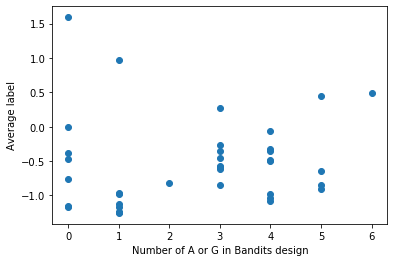

In [4]:
df_bandit = df[df['Group'] == 'bandit'][['RBS6', 'AVERAGE', 'STD']]
num_ags = []

for rbs6 in np.asarray(df_bandit['RBS6']):
    num = 0
    for i in rbs6:
        if i == 'A' or i == 'G':
            num+=1
    num_ags.append(num)
    
plt.scatter(num_ags, np.asarray(df_bandit['AVERAGE']))
plt.xlabel('Number of A or G in Bandits design')
plt.ylabel('Average label')

Text(0, 0.5, 'Number of sequences')

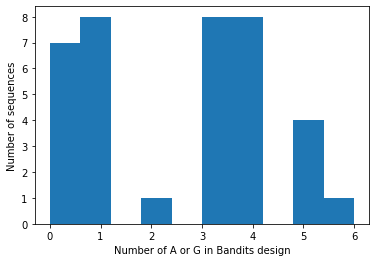

In [5]:
plt.hist(num_ags)
plt.xlabel('Number of A or G in Bandits design')
plt.ylabel('Number of sequences')

## Violinplot with AVERAGE value

In [6]:
df.sort_values(by = ['AVERAGE'], ascending = False).head(10)

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6,Change_Pos,Base
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,3.194925,2.783529,1.798618,2.592357,0.717515,0.246643,reference,AGGAGA,1.0,T
47,47,TTTAAGAAGGAGATAAACAT,RBS_1by1_48,2.646252,1.974373,0.904755,1.841793,0.878286,0.246420,bps_noncore,AGGAGA,16.0,A
28,10,TTTGAGAAGGAGATATACAT,RBS_1by1_11,2.156071,2.110693,0.956545,1.741103,0.679826,0.171995,bps_noncore,AGGAGA,4.0,G
25,7,TTGAAGAAGGAGATATACAT,RBS_1by1_8,1.775556,1.689308,NaN,1.732432,0.060987,0.174465,bps_noncore,AGGAGA,3.0,G
21,3,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.986839,1.948917,1.101241,1.678999,0.500712,0.169798,bps_noncore,AGGAGA,1.0,A
22,4,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.830061,2.201733,0.983436,1.671743,0.624388,0.117162,bps_noncore,AGGAGA,2.0,C
29,11,TTTTAGAAGGAGATATACAT,RBS_1by1_12,2.249207,1.478876,1.148303,1.625462,0.564901,0.264738,bps_noncore,AGGAGA,4.0,T
59,59,TTTAAGAAGGAGATATACAA,RBS_1by1_60,2.773016,1.956969,0.119449,1.616478,1.359156,0.262133,bps_noncore,AGGAGA,20.0,A
19,1,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.844257,1.678119,1.290106,1.604161,0.284382,0.185590,bps_noncore,AGGAGA,1.0,C
139,137,TTTAAGACTTTTTTATACAT,RBS_BA_48,1.631655,2.432684,0.716013,1.593451,0.858973,0.095234,bandit,CTTTTT,NaN,NaN


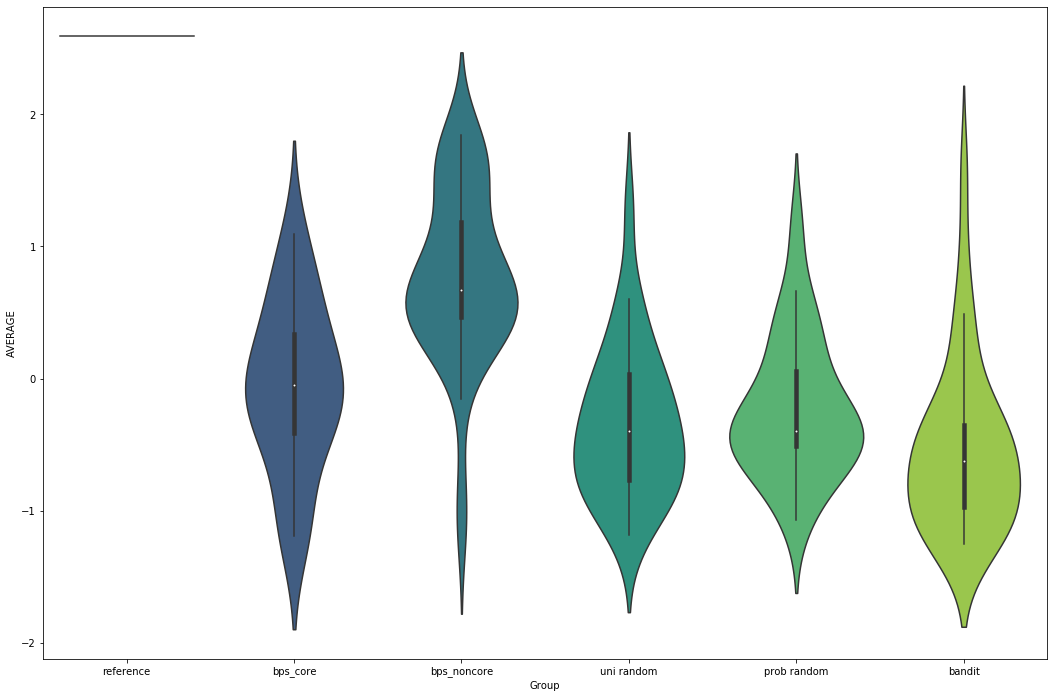

In [15]:
fig, ax = plt.subplots( figsize=(18,12))
sns.violinplot(x="Group", y="AVERAGE", data=df,palette='viridis')

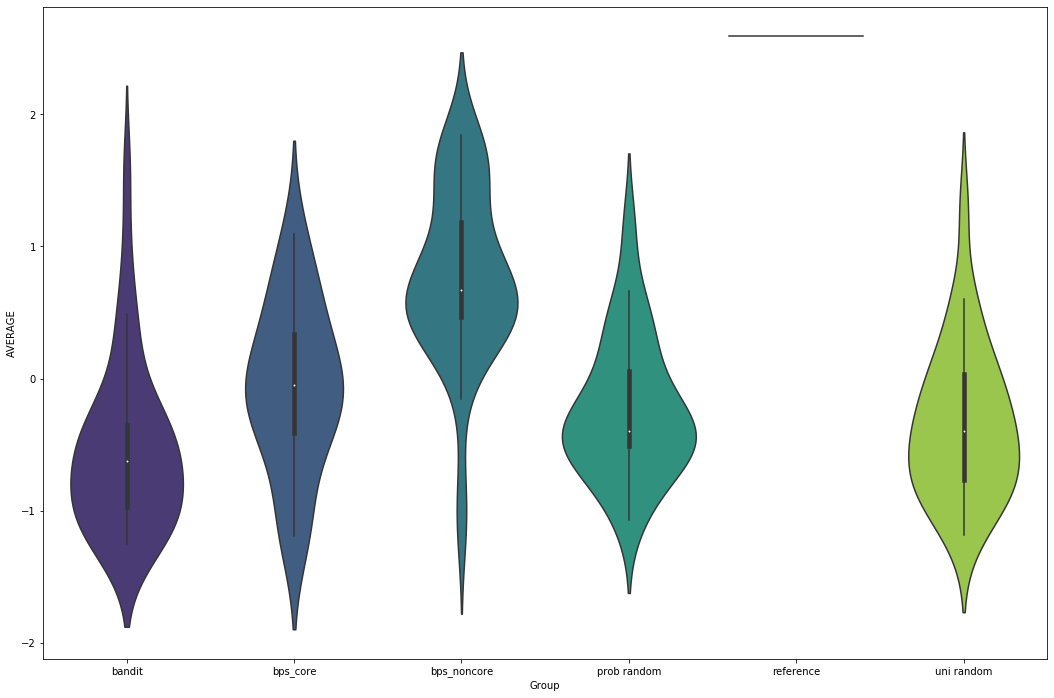

In [14]:
dfv = df.copy(deep=True)

for index, row in dfv.iterrows():
    if row['Group'] == 'bps' and row['RBS6'] == 'AGGAGA':
        row['Group'] = 'bps_ncore'
        dfv = dfv.append(row, ignore_index=True)
    elif row['Group'] == 'bps' and row['RBS6'] != 'AGGAGA':
        row['Group'] = 'bps_core'
        dfv = dfv.append(row, ignore_index=True)      
        
dfv.sort_values(by = ['Group'], ascending = True,inplace=True) 

dfv.head(300)

fig, ax = plt.subplots( figsize=(18,12))
sns.violinplot(x="Group", y="AVERAGE", data=dfv,palette='viridis')

## Violinplot with all replications

In [9]:
df_all_rep = pd.melt(df, id_vars=['RBS', 'Group'], value_vars=['Rep1', 'Rep2', 'Rep3'])
df_all_rep = df_all_rep.dropna()

In [10]:
df_all_rep.sort_values(by = ['value'], ascending = False).head(10)

,RBS,Group,variable,value
0,TTTAAGAAGGAGATATACAT,reference,Rep1,3.194925
150,TTTAAGAAGGAGATATACAT,reference,Rep2,2.783529
59,TTTAAGAAGGAGATATACAA,bps_noncore,Rep1,2.773016
47,TTTAAGAAGGAGATAAACAT,bps_noncore,Rep1,2.646252
289,TTTAAGACTTTTTTATACAT,bandit,Rep2,2.432684
29,TTTTAGAAGGAGATATACAT,bps_noncore,Rep1,2.249207
172,TCTAAGAAGGAGATATACAT,bps_noncore,Rep2,2.201733
28,TTTGAGAAGGAGATATACAT,bps_noncore,Rep1,2.156071
178,TTTGAGAAGGAGATATACAT,bps_noncore,Rep2,2.110693
21,ATTAAGAAGGAGATATACAT,bps_noncore,Rep1,1.986839


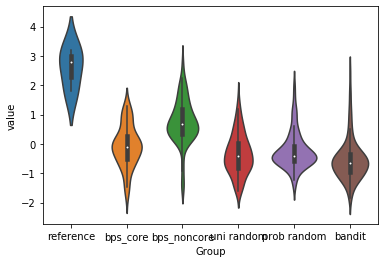

In [11]:
sns.violinplot(x="Group", y="value", data=df_all_rep)

## Predict labels with baseline data as training data

In [12]:
import pickle

with open('trained_reg_model.pickle', 'rb') as handle:
    trained_reg_model_dict = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: 'trained_reg_model.pickle'

In [ ]:
trained_reg_model_dict

In [ ]:
first_round_seq = Rewards_env(np.asarray(df[['RBS', 'AVERAGE']]), 'label').embedded
df['predict mean'], df['predict std']= trained_reg_model_dict['Baseline data_First round result_GPR_Spectrum_Kernel_label'].predict(first_round_seq, return_std=True)
# df['AVERAGE'] = (df['AVERAGE']-df['AVERAGE'].mean())/df['AVERAGE'].std()
df.head()

In [ ]:
df.sort_values(by = ['AVERAGE'], ascending = False).head(10)

In [ ]:
lm = sns.violinplot(x="Group", y="predict mean", data=df)
axes = lm.axes
axes.set_ylim(-2,4)

In [ ]:
sns.violinplot(x="Group", y="value", data=df_all_rep)